In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import scipy.io as sio
from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("mps") # apple silicon
# device = torch.device("cpu") # cpu
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # nvidia
print(f'device: {device}')

def to_tensor(x, device=torch.device("cpu")): return torch.tensor(x, dtype=torch.float32, device=device)

device: mps


In [2]:
#best mse loss: 0.087

In [3]:
# # download datasets from gdrive
# import gdown
# gdown.download(id="1-5KP7_OYIvDD_QXvIr5sDihVxZx1qJCN", output='mg_data/ITER_like_equilibrium_dataset_sample.mat', quiet=False)
# gdown.download(id="1Gn_OrMzxPRkTk-i77--HiWmWZyd8i8ue", output='mg_data/ITER_like_equilibrium_dataset.mat', quiet=False)

In [4]:
MODEL_SAVE_PATH = "mg_data/mg_planet.pth"
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 3e-3
USE_CURRENTS = True
USE_PROFILES = False
USE_MAGNETIC = True
INPUT_SIZE = int(USE_CURRENTS)*14 + int(USE_PROFILES)*202 + int(USE_MAGNETIC)*187

In [5]:
SAMPLE_DS_PATH = "mg_data/ITER_like_equilibrium_dataset_sample.mat" # sample dataset
FULL_DS_PATH = 'mg_data/ITER_like_equilibrium_dataset.mat' # full dataset
sample_ds_mat = sio.loadmat(SAMPLE_DS_PATH)
full_ds_mat = sio.loadmat(FULL_DS_PATH)
print(f"sample_ds_mat keys: {sample_ds_mat.keys()}")

sample_ds_mat keys: dict_keys(['__header__', '__version__', '__globals__', 'DB_meas_Bpickup_test_ConvNet', 'DB_psi_pixel_test_ConvNet', 'DB_res_RHS_pixel_test_ConvNet', 'DB_Jpla_pixel_test_ConvNet', 'DB_coils_curr_test_ConvNet', 'RR_pixels', 'ZZ_pixels', 'DB_separatrix_200_test_ConvNet', 'XP_YN', 'DB_f_test_ConvNet', 'DB_p_test_ConvNet'])


- mean current: -10183.76, std current: 34209.11
- mean magnetic: -0.20, std magnetic: 0.58
- mean f_profile: 33.13, std f_profile: 0.28
- mean p_profile: 9654.42, std p_profile: 8788.29

In [6]:
class PlaNetDataset(Dataset):
    def __init__(self, ds_mat):
        # output: magnetic flux, transposed (matlab is column-major)
        self.psi = to_tensor(ds_mat["DB_psi_pixel_test_ConvNet"].transpose(0, 2, 1)) # (n, 64, 64)
        # inputs: radial and vertical position of pixels (for plotting only rn) + currents + measurements + profiles 
        self.rr_pix = ds_mat["RR_pixels"] # radial position of pixels (64, 64)
        self.zz_pix = ds_mat["ZZ_pixels"] # vertical position of pixels (64, 64)
        self.currs = ds_mat["DB_coils_curr_test_ConvNet"] # input currents (n, 14)
        self.magn_meas = ds_mat["DB_meas_Bpickup_test_ConvNet"] # input magnetic measurements (n, 187)
        self.f_profile = ds_mat["DB_f_test_ConvNet"] # input profiles (n, 101)
        self.p_profile = ds_mat["DB_p_test_ConvNet"] # input profiles (n, 101)
        inputs = [] # add the normalized inputs to the list
        if USE_CURRENTS: inputs.append((to_tensor(self.currs)+10183)/34209) # (n, 14)
        if USE_MAGNETIC: inputs.append((to_tensor(self.magn_meas)+0.2)/0.58) # (n, 187)
        if USE_PROFILES: inputs.append(torch.cat(((to_tensor(self.f_profile)-33.13)/0.28, (to_tensor(self.p_profile)-9654)/8788), 1)) # (n, 202)
        self.inputs = torch.cat(inputs, 1) # (n, 403)
    def __len__(self): return len(self.psi)
    def __getitem__(self, idx): return self.inputs[idx], self.psi[idx]

In [7]:
# test dataset
ds = PlaNetDataset(sample_ds_mat)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")

Dataset length: 500
Input shape: torch.Size([201])
Output shape: torch.Size([64, 64])


In [8]:
# class PlaNet(nn.Module): # simple fully connected neural network > weak > loss:33 > converges to a constant
#     def __init__(self):
#         super(PlaNet, self).__init__()
#         self.n = 8
#         self.fc1 = nn.Linear(INPUT_SIZE, self.n)
#         self.fc2 = nn.Linear(self.n, self.n)
#         self.fc3 = nn.Linear(self.n, 64*64)
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         x = x.view(-1, 64, 64)
#         return x

In [9]:
# class PlaNet(nn.Module): # transpose convolutional neural network > stronger, fast, but artifacts
#     def __init__(self):
#         super(PlaNet, self).__init__()
#         self.n = n = 4
#         self.fc = nn.Sequential(
#             nn.Linear(INPUT_SIZE, 8*n),
#             nn.ReLU(),
#             nn.Linear(8*n, 16*n),
#             nn.ReLU(),
#         )
#         self.unconv = nn.Sequential(
#             nn.ConvTranspose2d(16*n, 8*n, kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm2d(8*n), # batch normalization
#             nn.ConvTranspose2d(8*n, 4*n, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(4*n, 2*n, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(2*n, n, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(n, 1, kernel_size=4, stride=2),
#         )
#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(-1, 16*self.n, 1, 1)
#         x = self.unconv(x)
#         x = x.view(-1, 64, 64)
#         return x

In [10]:
class PlaNet(nn.Module): # upsample convolutional neural network > slower > but smoother
    def __init__(self):
        super(PlaNet, self).__init__()
        self.interp = 'bilinear' # 'nearest' or 'bilinear'
        self.n = n = 2
        self.fc = nn.Sequential(
            nn.Linear(INPUT_SIZE, 8*n),
            nn.ReLU(),
            nn.Linear(8*n, 16*n),
            nn.ReLU(),
        )
        self.unconv = nn.Sequential(
            nn.Upsample(scale_factor=4, mode=self.interp),
            nn.Conv2d(16*n, 8*n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8*n), # batch normalization
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(8*n, 4*n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(4*n, 2*n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(2*n, n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(n, 1, kernel_size=3, padding=1),
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 16*self.n, 1, 1)
        x = self.unconv(x)
        x = x.view(-1, 64, 64)
        return x

In [11]:
# test model
model = PlaNet()
x = torch.randn(1, INPUT_SIZE)
print(f"Input shape: {x.shape}")
y = model(x)
print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 201])
Output shape: torch.Size([1, 64, 64])


In [ ]:
N = 6
A = np.zeros((N, N))
for n in range(N):
    for k in range(N):
        if n > k: A[n,k] = (2*n+1)**0.5 * (2*k+1)**0.5
        if n == k: A[n,k] = n+1
        if n < k: A[n,k] = 0

In [19]:
# Grad-Shafranov Operator Loss (PINN)
μ0 = 4*np.pi*1e-7
RRpix, ZZpix = sample_ds_mat["RR_pixels"], sample_ds_mat["ZZ_pixels"]
hr, hz = RRpix[0, 1] - RRpix[0, 0], ZZpix[1, 0] - ZZpix[0, 0]
RRin, ZZin = RRpix[1:-1,1:-1], ZZpix[1:-1,1:-1]
### Filters for GS equation
kr = np.array(([0, 0, 0], [1, -2, 1], [0, 0, 0]))*hz**2
kz = np.transpose(np.array(([0, 0, 0], [1, -2, 1], [0, 0, 0])))*hr**2
alfa = -2*(hr**2 + hz**2)
Laplace_kernel = np.array(([0, hr**2/alfa, 0], [hz**2/alfa, 1, hz**2/alfa], [0, hr**2/alfa, 0]))
Df_dr_kernel = np.array(([0, 0, 0], [+1, 0, -1], [0, 0, 0]))/(2*hr*alfa)*(hr**2*hz**2)
# Gaussian filter to slightly denoise output
# Gaussian_kernel = np.array(([1,2,1], [2,4,2], [1,2,1]))/16
Gaussian_kernel = np.array(([1,4,7,4,1],[4,16,26,16,4],[7,26,41,26,7],[4,16,26,16,4],[1,4,7,4,1]))/273
#convert to tensors
tRRconv = to_tensor(RRin).unsqueeze(0).unsqueeze(0)
tLaplace_kernel = to_tensor(Laplace_kernel[::-1,::-1].copy()).unsqueeze(0).unsqueeze(0)
tDf_dr_kernel = to_tensor(Df_dr_kernel[::-1,::-1].copy()).unsqueeze(0).unsqueeze(0)
tGaussian_kernel = to_tensor(Gaussian_kernel[::-1,::-1].copy()).unsqueeze(0).unsqueeze(0)

# def fun_GSoperator_NN_conv_batch(f):
#     Lpsi = F.conv2d(f, tLaplace_kernel)
#     Dpsi_dr = F.conv2d(f, tDf_dr_kernel)
#     Dpsi_dr = Dpsi_dr / tRRconv
#     return (Lpsi[:,:,:,0] - Dpsi_dr[:,:,:,0])*alfa / (hr**2 * hz**2) # GS operator

# def fun_GSoperator_NN_conv_smooth_batch(f):
#     Lpsi = F.conv2d(f, tLaplace_kernel)
#     print(f"Lpsi shape: {Lpsi.shape}")
#     Dpsi_dr = F.conv2d(f, tDf_dr_kernel)
#     print(f"Dpsi_dr shape: {Dpsi_dr.shape}")
#     Dpsi_dr = Dpsi_dr / tRRconv
#     print(f"Dpsi_dr shape: {Dpsi_dr.shape}")
#     GS_ope = (Lpsi - Dpsi_dr) * alfa / (hr**2 * hz**2)
#     # GS_ope = F.conv2d(GS_ope, tGaussian_kernel, padding='same')
#     GS_ope = torch.squeeze(GS_ope, dim=-1)
#     return GS_ope

def fun_GSoperator_conv_batch(f):
    Lpsi = F.conv2d(f, tLaplace_kernel)
    Dpsi_dr = F.conv2d(f, tDf_dr_kernel)
    Dpsi_dr = Dpsi_dr / tRRconv
    GS_ope = (Lpsi[:, :, :, 0] - Dpsi_dr[:, :, :, 0]) * alfa / (hr**2 * hz**2)
    jphi = -GS_ope / (μ0 * RRin)
    return GS_ope, jphi

print(f"tRRconv shape: {tRRconv.shape}")
print(f"tLaplace_kernel shape: {tLaplace_kernel.shape}")
print(f"tDf_dr_kernel shape: {tDf_dr_kernel.shape}")
print(f"tGaussian_kernel shape: {tGaussian_kernel.shape}")

tRRconv shape: torch.Size([1, 1, 62, 62])
tLaplace_kernel shape: torch.Size([1, 1, 3, 3])
tDf_dr_kernel shape: torch.Size([1, 1, 3, 3])
tGaussian_kernel shape: torch.Size([1, 1, 5, 5])


psi shape: (64, 64)
gs_gt shape: (64, 64)
gs_calc shape: torch.Size([62])


TypeError: Invalid shape (62,) for image data

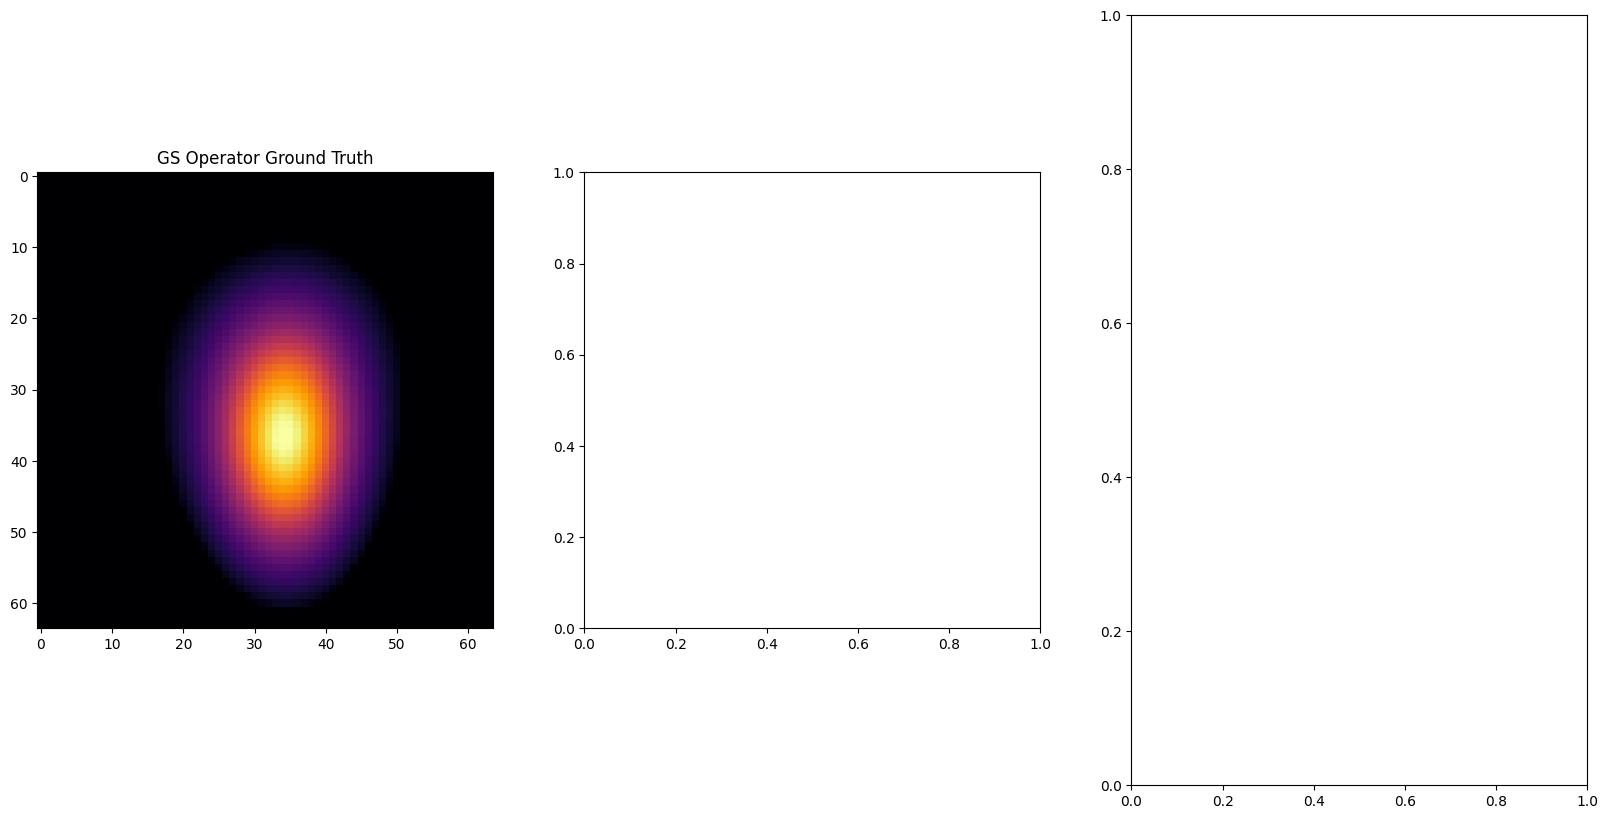

In [21]:
# test GS operator
idx = 10
gs_gt = sample_ds_mat["DB_res_RHS_pixel_test_ConvNet"][idx].transpose()
psi = sample_ds_mat["DB_psi_pixel_test_ConvNet"][idx].transpose()
print(f"psi shape: {psi.shape}")
# gs_calc = fun_GSoperator_NN_conv_smooth_batch(to_tensor(psi).unsqueeze(0).unsqueeze(0)).squeeze()
gs_calc = fun_GSoperator_conv_batch(to_tensor(psi).unsqueeze(0).unsqueeze(0))[0].squeeze()

print(f"gs_gt shape: {gs_gt.shape}")
print(f"gs_calc shape: {gs_calc.shape}")

#plot the GS operator
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(-gs_gt, cmap='inferno')
ax[0].set_title("GS Operator Ground Truth")
# plot the calculated GS operator
ax[1].imshow(gs_calc, cmap='inferno')
ax[1].set_title("GS Operator Calculated")
#plot psi
ax[2].imshow(psi, cmap='inferno')
ax[2].set_title("Psi Ground Truth");

In [ ]:
filter = torch.randn(1, 1, 3, 3)
input = torch.randn(1, 1, 64, 64)
output = F.conv2d(input, filter)
print(output.shape)

## Training

In [ ]:
train_ds, val_ds = PlaNetDataset(full_ds_mat), PlaNetDataset(sample_ds_mat) # initialize datasets
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
model = PlaNet()  # instantiate model
model.to(device) # move model to device
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss() # Mean Squared Error Loss
best_loss = float('inf') # initialize best loss
for epoch in range(EPOCHS): 
    epoch_time = time()
    model.train()
    trainloss, evalloss = [], []
    # for input_currs, psi in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
    for input_currs, psi in train_dl:
        input_currs, psi = input_currs.to(device), psi.to(device) # move to device
        optimizer.zero_grad()
        psi_pred = model(input_currs)
        loss = loss_fn(psi_pred, psi)
        loss.backward()
        optimizer.step()
        trainloss.append(loss.item())
    model.eval()
    with torch.no_grad():
        for input_currs, psi in val_dl:
            input_currs, psi = input_currs.to(device), psi.to(device) # move to device
            psi_pred = model(input_currs)
            loss = loss_fn(psi_pred, psi)
            evalloss.append(loss.item())
    print(f"Ep {epoch+1}: Train Loss: {sum(trainloss)/len(trainloss):.4f}, Eval Loss: {sum(evalloss)/len(evalloss):.4f}, Time: {time()-epoch_time:.2f}s,", end=" ")
    if sum(evalloss)/len(evalloss) < best_loss:
        best_loss = sum(evalloss)/len(evalloss)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("new best")
    else: print()

In [ ]:
model = PlaNet()
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()
ds = PlaNetDataset(sample_ds_mat)
# ds = PlaNetDataset(full_ds_mat)
for i in np.random.randint(0, len(ds), 10):  
    input_currs, psi = ds[i]
    psi_pred = model(input_currs.unsqueeze(0))
    psi_pred = psi_pred.detach().numpy().reshape(64, 64)
    psi = psi.detach().numpy().reshape(64, 64)
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    ext = [ds.rr_pix.min(), ds.rr_pix.max(), ds.zz_pix.min(), ds.zz_pix.max()]
    rr, zz = ds.rr_pix, ds.zz_pix  # radial and vertical positions of pixels
    bmin, bmax = np.min([psi, psi_pred]), np.max([psi, psi_pred])
    err = np.abs(psi - psi_pred)*100/abs(bmax - bmin)
    # err = np.abs(psi - psi_pred)*100/abs((psi + psi_pred)/2)
    err_mse = (psi - psi_pred)**2

    im0 = axs[0].imshow(psi, extent=ext, vmin=bmin, vmax=bmax)
    axs[0].set_title("Actual")
    axs[0].set_aspect('equal')
    fig.colorbar(im0, ax=axs[0]) 

    im1 = axs[1].imshow(psi_pred, extent=ext, vmin=bmin, vmax=bmax)
    axs[1].set_title("Predicted")
    axs[1].set_aspect('equal')
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(err, extent=ext, vmin=0, vmax=5)
    axs[2].set_title("Error")
    axs[2].set_aspect('equal')
    fig.colorbar(im2, ax=axs[2])

    im3 = axs[3].imshow(err_mse, extent=ext, vmin=0, vmax=0.5)
    axs[3].set_title("MSE")
    axs[3].set_aspect('equal')
    fig.colorbar(im3, ax=axs[3])

    c0 = axs[4].contour(rr, zz, psi, levels=15, cmap='viridis', linestyles='dashed')
    c1 = axs[4].contour(rr, zz, psi_pred, levels=10, cmap='viridis')
    axs[4].set_title("Contours")
    axs[4].set_aspect('equal')

    plt.tight_layout()
    plt.show()